#### https://github.com/numenta/nupic
#### Based on https://github.com/iizukak/ecg-htm  with modifications 

In [1]:
import sys
import csv
import datetime
import os
import pywt
import numpy
from collections import deque

In [2]:
# setting for fft conversion
FFT_SEGMENT_SIZE = 500
targetPath = 'disease_person1.csv'
outputPath = 'disease_person1_fft.csv'

In [3]:
targetFile = open(targetPath, "r")
csvReader = csv.reader(targetFile)
print("TARGET FILE PATH:", targetPath)

outputFile = open(outputPath, "w")
csvWriter = csv.writer(outputFile, lineterminator='\n')
print("OUTPUT FILE PATH:", outputPath)

('TARGET FILE PATH:', 'disease_person1.csv')
('OUTPUT FILE PATH:', 'disease_person1_fft.csv')


In [4]:
currentSegment = deque(maxlen = FFT_SEGMENT_SIZE)

# make initial segment
for i in range(FFT_SEGMENT_SIZE):
    date, value = csvReader.next()
    currentSegment.append(int(value))
print(currentSegment)

deque([433, 430, 427, 426, 427, 429, 427, 426, 426, 429, 430, 433, 437, 438, 437, 439, 442, 445, 446, 448, 452, 456, 461, 467, 471, 470, 470, 472, 472, 469, 469, 471, 474, 475, 477, 481, 485, 487, 491, 495, 497, 493, 492, 495, 496, 497, 499, 501, 502, 502, 504, 505, 504, 506, 508, 509, 513, 518, 523, 524, 526, 527, 527, 529, 531, 530, 528, 528, 527, 527, 527, 527, 523, 516, 509, 499, 493, 493, 493, 490, 486, 486, 486, 485, 485, 487, 487, 490, 491, 500, 541, 628, 738, 868, 949, 931, 831, 594, 385, 353, 384, 426, 463, 479, 480, 477, 476, 477, 480, 487, 495, 505, 513, 519, 524, 528, 534, 536, 541, 552, 560, 566, 572, 579, 588, 594, 599, 606, 610, 614, 622, 629, 632, 633, 638, 641, 639, 635, 629, 621, 610, 594, 577, 555, 529, 508, 494, 480, 464, 452, 445, 439, 432, 429, 430, 428, 423, 422, 420, 418, 417, 419, 420, 421, 422, 425, 425, 422, 423, 427, 428, 426, 426, 428, 429, 430, 433, 436, 438, 439, 441, 444, 444, 445, 447, 451, 452, 453, 456, 460, 460, 459, 461, 462, 461, 459, 459, 458, 455

In [5]:
# generate headers
header_row_1 = ["timestamp"]
for i in range(FFT_SEGMENT_SIZE / 2):
    header_row_1.append("f" + str(i))
header_row_2 = ["datetime"] + (["int"] * (FFT_SEGMENT_SIZE / 2))
header_row_3 = ["T"] + ([""] * (FFT_SEGMENT_SIZE / 2))

csvWriter.writerow(header_row_1)
csvWriter.writerow(header_row_2)
csvWriter.writerow(header_row_3)

In [6]:
hamm = numpy.hamming(FFT_SEGMENT_SIZE)
for row in csvReader:
    date, value = row[0], int(row[1])
    currentSegment.append(value)
    window = currentSegment * hamm
    # FFTValue = numpy.log(numpy.abs(numpy.fft.fft(window).real))
    # FFTValue = numpy.abs(numpy.fft.fft(window).real)
    # FFTValue = pywt.dwt(currentSegment ,"db1")[0]
    # FFTValue = numpy.log([numpy.sqrt(c.real ** 2 + c.imag ** 2) for c in numpy.fft.fft(window)][0:(FFT_SEGMENT_SIZE/2)])
    FFTValue = map(lambda x:float(x),
        [numpy.sqrt(c.real ** 2 + c.imag ** 2) for c in numpy.fft.fft(window)][0:(FFT_SEGMENT_SIZE/2)])

    # csvWriter.writerow(FFTValue)
    csvWriter.writerow([date] + FFTValue)

targetFile.close()
outputFile.close()

In [7]:
import csv
import datetime
import sys
import numpy
import pprint

from nupic.frameworks.opf.model_factory import ModelFactory
from nupic.encoders.adaptive_scalar import AdaptiveScalarEncoder

import model_params_generated as model_params

In [8]:
DEFAULT_DATA_PATH = "disease_person1_fft.csv"
DEFAULT_OUTPUT_PATH = "anomaly_scores.csv"
DATE_FORMAT = "%Y-%m-%d %H:%M:%S.%f"

In [9]:
def addScalarEncoders(params, vector_length):
    '''
    ase = AdaptiveScalarEncoder(21, n=109, clipInput=True)
    params["modelParams"]["sensorParams"]["encoders"].update({
          'vector': dict(
            length = vector_length,
            encoder = ase,
            name = 'vector',
            fieldname = 'vector',
            type= 'VectorEncoder')})
    '''

    for i in range(vector_length):
        sensor_name = "f" + str(i)
        params["modelParams"]["sensorParams"]["encoders"].update({ 
            sensor_name: {
              'clipInput': True,
              'fieldname': sensor_name,
              'n': 491,
              'name': sensor_name,
              'type': 'AdaptiveScalarEncoder',
              'w': 21}
        })
    return params

In [10]:
def createModel(verbose, vector_length):
    params = model_params.MODEL_PARAMS

    # loop and add scalarencoders of n-dimension
    params = addScalarEncoders(params, vector_length)

    model = ModelFactory.create(params)
    model.enableInference({"predictedField": "f50"})
    return model

In [11]:
def runCoordinateAnomaly(dataPath=DEFAULT_DATA_PATH, outputPath=DEFAULT_OUTPUT_PATH, verbose=True):

    with open (dataPath) as fin:
        reader = csv.reader(fin)
        csvWriter = csv.writer(open(outputPath,"wb"))
        '''
        csvWriter.writerow(["timestamp","anomaly_score",])
        '''  
        r = reader.next()
        r = reader.next()
        r = reader.next()
        fft_length = len(r) - 1
        model = createModel(verbose, fft_length)

        # it's dummy value. use valid value
        timestamp = datetime.datetime.strptime("2015-10-17 21:05:59.033917", DATE_FORMAT)
        for i, record in enumerate(reader, start=1):
            '''
            timestamp = datetime.datetime.fromtimestamp(int(record[1]) / 1e3)
            '''
            values = list(record[1:])
            values = map(lambda x: float(x), values)
            timestamp = timestamp + datetime.timedelta(microseconds=10000) 

            modelInput = {
                "timestamp": timestamp
            }
            for j in range(fft_length):
                sensor_name = "f" + str(j)
                modelInput.update({
                sensor_name: values[j]
                })
      
            result = model.run(modelInput)
            anomalyScore = result.inferences["anomalyScore"]

            csvWriter.writerow([anomalyScore])

            if verbose:
                print i, "[{0}] - Anomaly score: {1}.".format(timestamp, anomalyScore)

    print "Anomaly scores have been written to {0}".format(outputPath)

In [12]:
runCoordinateAnomaly()

1 [2015-10-17 21:05:59.043917] - Anomaly score: 1.0.
2 [2015-10-17 21:05:59.053917] - Anomaly score: 1.0.
3 [2015-10-17 21:05:59.063917] - Anomaly score: 1.0.
4 [2015-10-17 21:05:59.073917] - Anomaly score: 0.0.
5 [2015-10-17 21:05:59.083917] - Anomaly score: 0.0.
6 [2015-10-17 21:05:59.093917] - Anomaly score: 0.0.
7 [2015-10-17 21:05:59.103917] - Anomaly score: 0.0.
8 [2015-10-17 21:05:59.113917] - Anomaly score: 0.0.
9 [2015-10-17 21:05:59.123917] - Anomaly score: 0.0.
10 [2015-10-17 21:05:59.133917] - Anomaly score: 0.0.
11 [2015-10-17 21:05:59.143917] - Anomaly score: 0.0.
12 [2015-10-17 21:05:59.153917] - Anomaly score: 0.0.
13 [2015-10-17 21:05:59.163917] - Anomaly score: 0.0.
14 [2015-10-17 21:05:59.173917] - Anomaly score: 0.0.
15 [2015-10-17 21:05:59.183917] - Anomaly score: 0.0.
16 [2015-10-17 21:05:59.193917] - Anomaly score: 0.0.
17 [2015-10-17 21:05:59.203917] - Anomaly score: 0.0.
18 [2015-10-17 21:05:59.213917] - Anomaly score: 0.0.
19 [2015-10-17 21:05:59.223917] - Ano

149 [2015-10-17 21:06:00.523917] - Anomaly score: 0.324999988079.
150 [2015-10-17 21:06:00.533917] - Anomaly score: 0.0.
151 [2015-10-17 21:06:00.543917] - Anomaly score: 1.0.
152 [2015-10-17 21:06:00.553917] - Anomaly score: 0.0.
153 [2015-10-17 21:06:00.563917] - Anomaly score: 1.0.
154 [2015-10-17 21:06:00.573917] - Anomaly score: 0.0.
155 [2015-10-17 21:06:00.583917] - Anomaly score: 1.0.
156 [2015-10-17 21:06:00.593917] - Anomaly score: 0.0.
157 [2015-10-17 21:06:00.603917] - Anomaly score: 0.0.
158 [2015-10-17 21:06:00.613917] - Anomaly score: 0.0.
159 [2015-10-17 21:06:00.623917] - Anomaly score: 0.0.
160 [2015-10-17 21:06:00.633917] - Anomaly score: 0.0.
161 [2015-10-17 21:06:00.643917] - Anomaly score: 0.0.
162 [2015-10-17 21:06:00.653917] - Anomaly score: 0.0.
163 [2015-10-17 21:06:00.663917] - Anomaly score: 0.0.
164 [2015-10-17 21:06:00.673917] - Anomaly score: 0.0.
165 [2015-10-17 21:06:00.683917] - Anomaly score: 0.0.
166 [2015-10-17 21:06:00.693917] - Anomaly score: 0.0.

298 [2015-10-17 21:06:02.013917] - Anomaly score: 0.0.
299 [2015-10-17 21:06:02.023917] - Anomaly score: 0.0.
300 [2015-10-17 21:06:02.033917] - Anomaly score: 0.0.
301 [2015-10-17 21:06:02.043917] - Anomaly score: 0.0.
302 [2015-10-17 21:06:02.053917] - Anomaly score: 0.0.
303 [2015-10-17 21:06:02.063917] - Anomaly score: 0.0.
304 [2015-10-17 21:06:02.073917] - Anomaly score: 0.0.
305 [2015-10-17 21:06:02.083917] - Anomaly score: 0.0.
306 [2015-10-17 21:06:02.093917] - Anomaly score: 0.0.
307 [2015-10-17 21:06:02.103917] - Anomaly score: 0.0.
308 [2015-10-17 21:06:02.113917] - Anomaly score: 0.0.
309 [2015-10-17 21:06:02.123917] - Anomaly score: 0.0.
310 [2015-10-17 21:06:02.133917] - Anomaly score: 0.0.
311 [2015-10-17 21:06:02.143917] - Anomaly score: 0.0.
312 [2015-10-17 21:06:02.153917] - Anomaly score: 0.0.
313 [2015-10-17 21:06:02.163917] - Anomaly score: 0.0.
314 [2015-10-17 21:06:02.173917] - Anomaly score: 0.0.
315 [2015-10-17 21:06:02.183917] - Anomaly score: 0.0.
316 [2015-

448 [2015-10-17 21:06:03.513917] - Anomaly score: 0.0.
449 [2015-10-17 21:06:03.523917] - Anomaly score: 0.0.
450 [2015-10-17 21:06:03.533917] - Anomaly score: 0.0.
451 [2015-10-17 21:06:03.543917] - Anomaly score: 0.0.
452 [2015-10-17 21:06:03.553917] - Anomaly score: 0.0.
453 [2015-10-17 21:06:03.563917] - Anomaly score: 0.0.
454 [2015-10-17 21:06:03.573917] - Anomaly score: 0.0.
455 [2015-10-17 21:06:03.583917] - Anomaly score: 0.0.
456 [2015-10-17 21:06:03.593917] - Anomaly score: 0.0.
457 [2015-10-17 21:06:03.603917] - Anomaly score: 0.0.
458 [2015-10-17 21:06:03.613917] - Anomaly score: 0.0.
459 [2015-10-17 21:06:03.623917] - Anomaly score: 0.0.
460 [2015-10-17 21:06:03.633917] - Anomaly score: 0.0.
461 [2015-10-17 21:06:03.643917] - Anomaly score: 0.0.
462 [2015-10-17 21:06:03.653917] - Anomaly score: 0.0.
463 [2015-10-17 21:06:03.663917] - Anomaly score: 0.0.
464 [2015-10-17 21:06:03.673917] - Anomaly score: 0.0.
465 [2015-10-17 21:06:03.683917] - Anomaly score: 0.0.
466 [2015-

598 [2015-10-17 21:06:05.013917] - Anomaly score: 0.0.
599 [2015-10-17 21:06:05.023917] - Anomaly score: 0.0.
600 [2015-10-17 21:06:05.033917] - Anomaly score: 0.0.
601 [2015-10-17 21:06:05.043917] - Anomaly score: 0.0.
602 [2015-10-17 21:06:05.053917] - Anomaly score: 0.0.
603 [2015-10-17 21:06:05.063917] - Anomaly score: 0.0.
604 [2015-10-17 21:06:05.073917] - Anomaly score: 0.0.
605 [2015-10-17 21:06:05.083917] - Anomaly score: 0.0.
606 [2015-10-17 21:06:05.093917] - Anomaly score: 0.0.
607 [2015-10-17 21:06:05.103917] - Anomaly score: 0.0.
608 [2015-10-17 21:06:05.113917] - Anomaly score: 0.0.
609 [2015-10-17 21:06:05.123917] - Anomaly score: 0.0.
610 [2015-10-17 21:06:05.133917] - Anomaly score: 0.0.
611 [2015-10-17 21:06:05.143917] - Anomaly score: 0.0.
612 [2015-10-17 21:06:05.153917] - Anomaly score: 0.0.
613 [2015-10-17 21:06:05.163917] - Anomaly score: 0.0.
614 [2015-10-17 21:06:05.173917] - Anomaly score: 0.0.
615 [2015-10-17 21:06:05.183917] - Anomaly score: 0.0.
616 [2015-

In [29]:
import pandas as pd 
import numpy as np

In [20]:
data = pd.read_csv('disease_person1.csv', header=-1)

In [23]:
score = pd.read_csv('anomaly_scores.csv', header = -1)

In [38]:
len(data[500:]) == len(score)

True

In [15]:
import matplotlib.pyplot as plt

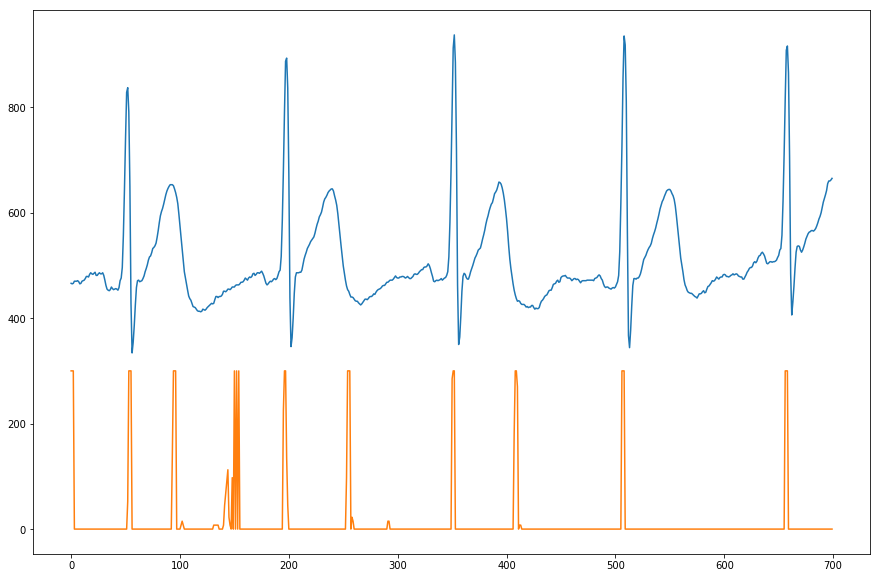

In [34]:
plt.figure(figsize=(15,10))
plt.plot(np.array(data[1][500:]))
plt.plot(300*score)
plt.show()